# BikeMaps.Org Data for Victoria, BC

## Data Exploration

### Loading Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import numpy as np
import pysal
import pysal.spatial_dynamics.interaction as interaction
np.random.seed(100)
import datetime


from IPython.display import IFrame, Image, HTML, display, YouTubeVideo
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns  # Makes for nicer plots
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4
from matplotlib.patches import Ellipse, Circle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import interact, interactive, fixed

import scipy
import treelib
import pyclust
from scipy.spatial.distance import squareform, pdist
import sklearn
from sklearn.cluster import KMeans


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

## Collisions Data Set

In [5]:
collisions = pd.read_csv('/Users/marthamorrissey/Documents/STA_project_MM/Data/col.csv')
collisions.dtypes

i_type               object
incident_with        object
date                 object
p_type               object
details              object
incident_effect      object
injury               object
trip_purpose         object
regular_cyclist      object
helmet               object
intoxicated          object
road_conditions      object
sightlines           object
cars_on_roadside     object
riding_on            object
bike_lights          object
terrain              object
direction            object
turning              object
age                 float64
birthmonth          float64
sex                  object
pk                    int64
x                   float64
y                   float64
dtype: object

In [6]:
date = collisions['date']

def changetime(x):
    t1 = pd.to_datetime(x, format ='%Y-%m-%dT%H:%M:%S')
    #t2 = pd.Timestamp(np.datetime64(t1))
    t3 = t1.to_pydatetime()
    return t3
                               
collisions['T_test3'] = collisions['date'].apply(changetime)
collisions['just_date'] = collisions['T_test3'].dt.date

In [7]:
ordered_c = collisions.sort_values(by = 'T_test3') 

ordered_c.reset_index(inplace=True)

def time_diff(x):
    timesince = x - ordered_c['T_test3'][0] 
    return int(timesince.total_seconds() / 36000) 
#want resolution in time to be similar to the resolution in space 

ordered_c['hrs_since_firstcrash'] = ordered_c['T_test3'].apply(time_diff)

#ordered_c.head()

## Scaling Data

### Temporal

In [93]:
c_st = ordered_c[['x', 'y' , 'hrs_since_firstcrash']]

scaled_matrix = sklearn.preprocessing.scale(c_st)

scaled_df = pd.DataFrame(scaled_matrix)
scaled_df.columns = ['x_scaled', 'y_scaled', 'time_scaled']

scaled_df.head()


t = np.array(scaled_df['time_scaled'])
t2 = t[t != 0 ]

len(t2)

min_t = ( str(min(np.diff(t2))))
max_t = (str(max(np.diff(t2))))
mean_t = (str(np.mean(np.diff(t2))))
med_t = ((np.median(np.diff(t2))))

#Average time apart is .029 units of scaled time, will be rounded to 0.03 for the knox test 

### Spatial

In [87]:
scaled_df_locations = scaled_df[['x_scaled', 'y_scaled']]

scaled_df_locations.head()

loc = scaled_df_locations.as_matrix()

dist = pdist(loc, 'euclidean')

dist_o = (np.sort(dist))

test = scipy.spatial.distance.squareform(dist)

test = np.asmatrix(test)

test2 = test[test !=0]

test2.A1

min_s = (str(np.min(test2.A1)))
med_s = (str(np.median(test2.A1)))
mean_s =(str(np.mean(test2.A1)))
max_s =(str(np.max(test2.A1)))



# Exploratory Visualization

## Where is Scaled Space and Regular Space?

### Visualization based on code from Carson's STA Lecture 4.

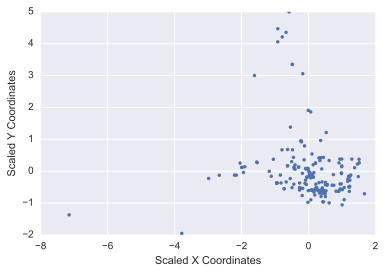

In [25]:
#np.array(c_st['x_binned'])

ax = plt.figure(figsize=(6, 4)).gca()
#ax.plot(events.space[:, 0], events.space[:, 1], ".")

ax.plot(np.array(scaled_df['x_scaled']), np.array(scaled_df['y_scaled']), ".")


ax.set_xlabel("Scaled X Coordinates")
ax.set_ylabel("Scaled Y Coordinates")
plt.show()

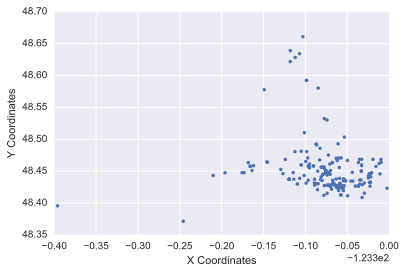

In [26]:
c_st.head()


ax = plt.figure(figsize=(6, 4)).gca()
ax.plot(np.array(c_st['x']), np.array(c_st['y']), ".")
ax.set_xlabel("X Coordinates")
ax.set_ylabel("Y Coordinates")
plt.show()

## Where in Scaled Time and Regular Time?

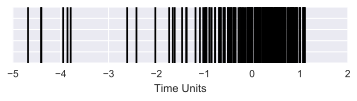

In [57]:
ax = plt.figure(figsize=(6, 1)).gca()
ax.vlines(np.array(scaled_df['time_scaled']), 0, 1)
ax.set_xlabel("Time Units")
plt.tick_params(axis='y', which='both', labelleft='off') 
plt.show()

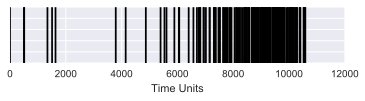

In [28]:
ax = plt.figure(figsize=(6, 1)).gca()
ax.vlines(np.array(c_st['hrs_since_firstcrash']), 0, 1)
ax.set_xlabel("Time Units")
plt.tick_params(axis='y', which='both', labelleft='off') 
plt.show()

## Where in Binned Space-Time and Regular Space-Time?

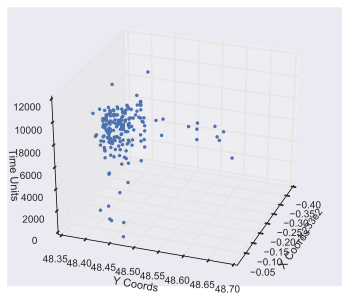

In [29]:
@interact(angle=(0, 240, 5))  
def make_plot(angle):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)  # Use 'angle' parameter
    ax.set_ylabel("Y Coords")
    ax.set_xlabel("X Coords")
    ax.set_zlabel("Time Units")
    ax.plot((np.array(c_st['x'])), np.array(c_st['y']), np.array(c_st['hrs_since_firstcrash']), ".")
    plt.show()

## Determining Knox Test Parameters

Using nearest neighbor.

In [10]:
scaled_df.to_csv('/Users/marthamorrissey/Documents/STA_project_MM/Data/scaled.csv')

In [11]:
path = "/anaconda/lib/python3.5/site-packages/pysal/examples/burkitt/burkitt.shp" 

#hacking work around- re-named my data to match the example data in PySAL examples folder 

In [12]:
#Modified Knox Test 

events = interaction.SpaceTimeEvents(path, 'time_scale')
events.n

result = interaction.modified_knox(events.space, events.t,delta=1.5,tau=.008,permutations=99)

#print("%2.8f"%result['stat'])

#events.n

print(result)

{'pvalue': 0.90000000000000002, 'stat': -5.3923076923076962}


In [13]:
 print(result['stat'])

-5.39230769231


In [14]:
#Knox Test

#.003 + median for time 
# mean of space 
result = interaction.knox(events.space, events.t ,delta= 1.5 ,tau=.08,permutations=999)
print(result['stat'])

#89
#.04 
#changes so much each time test is run because of permutation 

print(result)

#print("%2.2f"%result['pvalue']) #can reject null hypothesis that there was no interaction in space and time

905
{'pvalue': array([ 0.018]), 'stat': 905}


In [15]:
#Mantel Test

mt = interaction.mantel(events.space, events.t,99,scon=0.0,spow=1.0,tcon=0.0,tpow=1.0)


print("%6.6f"%mt['stat'])

print("%2.2f"%result['pvalue'])

//anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = getattr(asarray(obj), method)(*args, **kwds)


-0.024671
0.02


In [16]:
result_j = interaction.jacquez(events.space, events.t ,k=3,permutations=999)

print(result_j['stat'])

print("%3.1f"%result_j['pvalue'])

5
0.9


# Distance Accounting for Space and Time

In [17]:
c_st = ordered_c[['x', 'y' , 'hrs_since_firstcrash']]

c_st.head()

#cut_points = []
#x = pd.qcut(c_st['x'], 10)

scaled_matrix = sklearn.preprocessing.scale(c_st)
scaled_df = pd.DataFrame(scaled_matrix)
scaled_df.columns = ['x_scaled', 'y_scaled', 'time_scaled']

scaled_df.head()

,x_scaled,y_scaled,time_scaled
0,1.293679,0.379843,-4.683605
1,0.396250,0.072192,-4.409725
2,0.414528,-0.529424,-4.404805
3,1.171625,-0.318692,-3.949432
4,0.617992,-0.994221,-3.858685


In [18]:
import scipy
import sklearn
from sklearn.cluster import KMeans

In [80]:
#y = pdist(st_matrix, 'euclidean')

y = pdist(scaled_matrix, 'euclidean')

y

np.sort(y)

st_distance = y[y != 0]

med_st = (np.median(np.ravel(st_distance)))
mean_st = (np.mean(np.ravel(st_distance)))
min_st = (np.min(np.ravel(st_distance)))
max_st = (np.max(np.ravel(st_distance)))
#space-time distance

In [96]:
d = {'space': pd.Series([min_s, med_s, mean_s, max_s], index = ['min', 'median', 'mean', 'max']), 
     'time' : pd.Series([min_t, med_t, mean_t, max_t], index = ['min', 'median', 'mean', 'max']),
     'space time': pd.Series([min_st, med_st, mean_st, max_st], index = ['min', 'median', 'mean', 'max'])
    
    }

nearest_neighbor_distances = pd.DataFrame(d)

nearest_neighbor_distances

,space,space time,time
min,0.000118806261686,0.013299,0.0
median,1.10265226632,1.566126,0.00765333
mean,1.50962465939,2.005001,0.0296769851493
max,9.14671178912,9.850341,1.18025308263


In [20]:
z = KMeans(n_clusters=3).fit_predict(scaled_matrix)


len(z) #add this to graph and color-code bythese 3 clusters 
z
z_distance= KMeans(n_clusters =3).fit_predict(scaled_matrix)



In [21]:
c_st['clutser'] = z

c_st.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,x,y,hrs_since_firstcrash,clutser
0,-123.319393,48.468653,0,1
1,-123.359427,48.455830,501,1
2,-123.358612,48.430752,510,1
3,-123.324838,48.439536,1343,1
4,-123.349536,48.411378,1509,1


## DBSCAN Clustering 

1: uses eps 1.6 (the median nearest neighbor distance) and minimum number of samples as 20)

2: uses eps of 1 (the average of the median and the mean nearest neighbor distance)

# DBSCAN implementation 1

In [48]:
from sklearn.cluster import DBSCAN

cluster = sklearn.cluster.DBSCAN(eps = 1.6 , min_samples =20).fit(scaled_matrix) #change that number 

labels = cluster.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)



#db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(cluster.labels_, dtype=bool)
core_samples_mask[cluster.core_sample_indices_] = True


#print('Estimated number of clusters: %d' % n_clusters_)

#print(labels)
print(n_clusters_)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(scaled_matrix, labels))
print(labels)

1
Estimated number of clusters: 1
Silhouette Coefficient: 0.609
[-1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0
  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


//anaconda/lib/python3.5/site-packages/matplotlib/lines.py:1106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._markerfacecolor != fc:


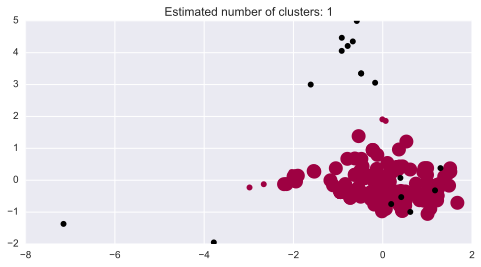

In [49]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = scaled_matrix[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = scaled_matrix[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

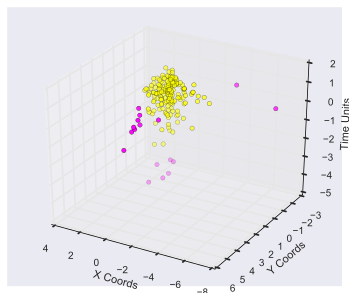

In [50]:

@interact(angle=(0, 240, 5))
def make_plot(angle):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)  # Use 'angle' parameter
    ax.set_ylabel("Y Coords")
    ax.set_xlabel("X Coords")
    ax.set_zlabel("Time Units")
    ax.scatter((np.array(scaled_df['x_scaled'])),
               np.array(scaled_df['y_scaled']), 
               np.array(scaled_df['time_scaled']),
               c=labels, cmap= 'spring') 
    
    plt.show()

## DBSCAN implemtation 2

In [52]:
from sklearn.cluster import DBSCAN

cluster = sklearn.cluster.DBSCAN(eps = .5 , min_samples =5).fit(scaled_matrix) #change that number 

labels2 = cluster.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)



#db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(cluster.labels_, dtype=bool)
core_samples_mask[cluster.core_sample_indices_] = True


#print('Estimated number of clusters: %d' % n_clusters_)

#print(labels)
print(n_clusters_)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(scaled_matrix, labels2))
print(labels2)

2
Estimated number of clusters: 2
Silhouette Coefficient: 0.337
[-1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0 -1 -1  0 -1  0  0  0  0  0 -1 -1  0 -1
 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0 -1  0  0 -1  0
 -1  0  0 -1 -1  0 -1  0  1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1 -1
  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0 -1  1  0
  0  0  0  0  0  0  1 -1  0  0  0  0  0  0 -1  0  0  0  0  0  1  0  0  0 -1
  0  0  0 -1  0  0  0  1  0  1  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]


//anaconda/lib/python3.5/site-packages/matplotlib/lines.py:1106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._markerfacecolor != fc:


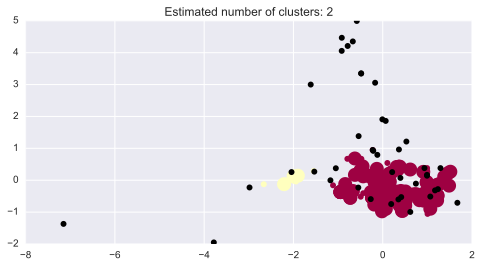

In [54]:
unique_labels = set(labels2)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels2 == k)

    xy = scaled_matrix[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = scaled_matrix[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

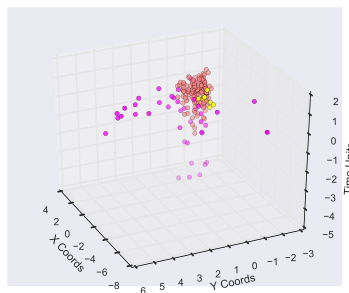

In [55]:

@interact(angle=(0, 240, 5))
def make_plot(angle):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)  # Use 'angle' parameter
    ax.set_ylabel("Y Coords")
    ax.set_xlabel("X Coords")
    ax.set_zlabel("Time Units")
    ax.scatter((np.array(scaled_df['x_scaled'])),
               np.array(scaled_df['y_scaled']), 
               np.array(scaled_df['time_scaled']),
               c=labels, cmap= 'spring') 
    
    plt.show()

In [105]:
import shapely

In [106]:
fpath = '/Users/marthamorrissey/Documents/STA_project_MM/Data/NeighbourhoodsSHP/Neighbourhoods.shp'

In [116]:
import matplotlib
matplotlib.import_module('mpl_toolkits').__path__

AttributeError: module 'matplotlib' has no attribute 'import_module'

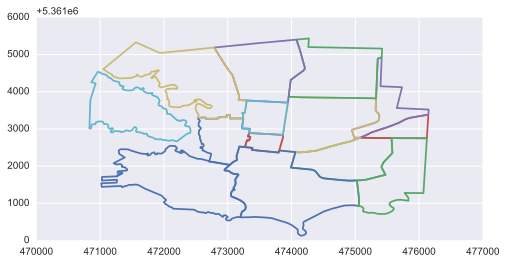

In [112]:
import shapefile as shp
import matplotlib.pyplot as plt

sf = shp.Reader(fpath)

plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

In [124]:
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection

import mpl_toolkits
from mpl_toolkits.basemap import Basemap

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

ImportError: No module named 'mpl_toolkits.basemap'

In [121]:
shp = fiona.open(fpath)
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [123]:
m = mpl_toolkits.Basemap(
    projection='tmerc',
    lon_0=-2.,
    lat_0=49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    fpath,
    color='none',
    zorder=2)

AttributeError: module 'mpl_toolkits' has no attribute 'Basemap'